# Spam Detection 

First of all import necessary graph tools and numpy tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
%matplotlib inline

Read the CSV file provided and lets print the first five entry to see the data contents.
Since the CSV file contained latin encoding we are reading the file with latin encoder

In [2]:
sms = pd.read_csv("./spam.csv", encoding='latin-1')

sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Since there are some unused columns we shall proceed with removing those column.
We shall rename v1 column to class which gives us the classificaiton wheather message is spam or ham and second column will be renamed to message since it contains the sms message

In [3]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'class','v2':'message'})

After performing some cleanup process we shall examine our data

In [4]:
sms.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Lets try to see if there are any correlation between length of the word and there correlation to class column

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027BA7E6DBA8>,
      dtype=object)

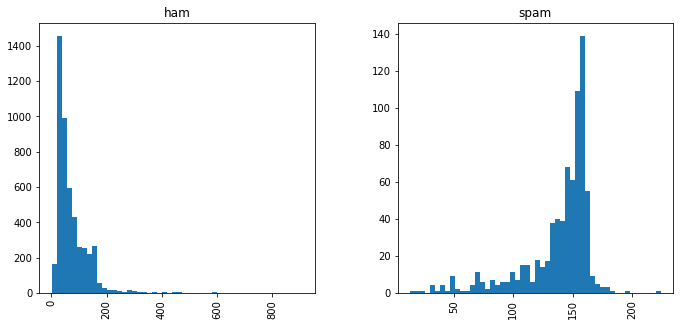

In [5]:
sms['length'] = sms['message'].apply(len)
sms.hist(column='length', by='class', bins=50,figsize=(11,5))

We do see that higher the word count higher is the probability of the message being a spam. But lets not get biased with that since we do see that smaller text are also spam messages

As part of this exercise, let us import 3 main model ie., Gaussian, Bernoulli and Multinomial naive bayes model

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [7]:
mnb = MultinomialNB(alpha=0.2)
bnb = BernoulliNB(alpha=0.2)
gnb = GaussianNB()

In [8]:
clfs = {'GNB' : gnb ,'BNB' : bnb, 'MNB': mnb}

In [9]:
from sklearn.model_selection import KFold

In [10]:
text_feat = sms['message'].copy()

This function splits the message to array of words and removes any stop words and then joins the array to form message without any stop words

In [11]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [12]:
import nltk
nltk.download('stopwords')
text_feat = text_feat.apply(text_process)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\npune\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
vectorizer = TfidfVectorizer("english")

We perform TF IDF vectorization to the above filtered SMS 

In [14]:
features = vectorizer.fit_transform(text_feat)
feature_names = vectorizer.get_feature_names()
dense = features.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)


We perform K-fold cross validation with K being 10

In [15]:
kf = KFold(n_splits=10) # Define the split - into 10 folds 
kf.get_n_splits(dense) # returns the number of splitting iterations in the cross-validator
kf

KFold(n_splits=10, random_state=None, shuffle=False)

Using our K Fold technique we shall iterate through our model, generate training and testing data.

We shall train our model and then generate score for each iteration to see how our models are getting trained

In [16]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)
def predict_labels(clf, features):
    return (clf.predict(features))

In [17]:
pred_scores = []
i=0
for train_index, test_index in kf.split(dense):
    features_train, features_test = dense[train_index], dense[test_index]
    labels_train, labels_test = sms['class'][train_index], sms['class'][test_index]
    i+=1
    for k,v in clfs.items():
        train_classifier(v, features_train, labels_train)
        pred = predict_labels(v,features_test)
        pred_scores.append((k + "- Gen " + str(i), [accuracy_score(labels_test,pred)]))

After our model are trained we shall see how good our model have been performed using our score generated in previous cell

In [18]:
import collections
df = pd.DataFrame.from_dict(collections.OrderedDict(pred_scores),orient='index', columns=['Score'])
df

,Score
GNB- Gen 1,0.897849
BNB- Gen 1,0.987455
MNB- Gen 1,0.992832
GNB- Gen 2,0.890681
BNB- Gen 2,0.983871
MNB- Gen 2,0.978495
GNB- Gen 3,0.885099
BNB- Gen 3,0.976661
MNB- Gen 3,0.974865
GNB- Gen 4,0.894075


We see that Bernoulli and Multinomal model perform equally better but Gaussian model performs inferior in comparision with the other two model

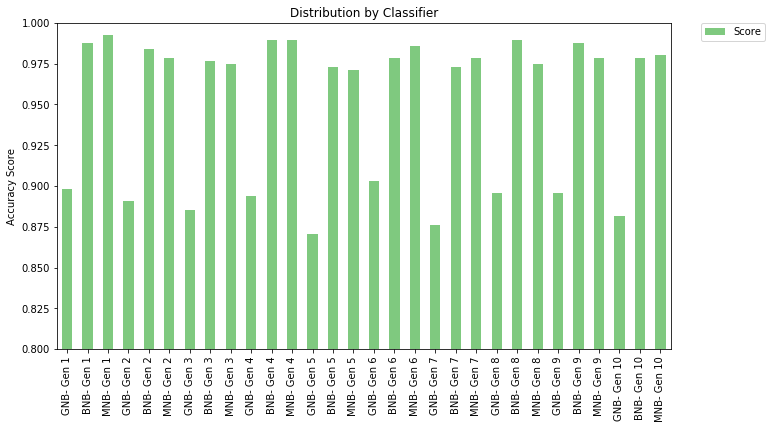

In [19]:
df.plot(kind='bar', ylim=(0.8,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(3*10), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)